In [1]:
%load_ext autotime

import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from scipy import interpolate
from scipy import stats
from datetime import datetime, timedelta
import pytz
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects
import geopandas as gpd
import tqdm.auto as tqdm
from glob import glob
import ee
from shapely.ops import split
from shapely import line_merge
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

In [2]:
service_account = 'service-account@iron-dynamics-294100.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '.private-key.json')
ee.Initialize(credentials)

In [3]:
sitename = "nzd0188"
vos = pd.read_csv(f"shoreline_data_run6/New_Zealand/{sitename}/time_series_raw.csv")
vos.drop(columns="Unnamed: 0", inplace=True)
vos.set_index("dates", inplace=True)
vos.index = pd.to_datetime(vos.index)
vos

,nzd0188-0000,nzd0188-0001,nzd0188-0002,nzd0188-0003,nzd0188-0004,nzd0188-0005,nzd0188-0006,nzd0188-0007,nzd0188-0008,nzd0188-0009,nzd0188-0010,nzd0188-0011,nzd0188-0012,nzd0188-0013,nzd0188-0014
dates,,,,,,,,,,,,,,,
1999-08-12 21:52:44+00:00,196.828629,190.268379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,157.275274,160.324198,NaN,NaN,178.492409,171.223156
1999-08-19 21:58:52+00:00,207.485765,196.580927,195.307019,185.763909,179.419632,181.116426,177.300310,176.733878,169.656241,172.787792,180.749103,186.358245,183.475767,183.119576,NaN
1999-09-13 21:52:41+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.448816,NaN,NaN,185.438392,186.709556
1999-09-29 21:52:52+00:00,213.975717,203.984667,201.525830,202.736133,194.038465,189.686439,198.867256,193.963189,190.388081,193.107355,198.635200,208.950190,201.377834,199.960787,198.516028
1999-10-15 21:52:49+00:00,209.211102,199.819992,194.981584,191.413944,184.906999,186.674699,182.363095,180.816647,174.956075,175.884418,190.418498,206.180365,204.797575,196.827495,193.010532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-17 22:00:08+00:00,205.980687,201.920716,201.260355,192.136697,202.977916,187.639290,176.355046,179.283420,180.109304,184.509166,181.356575,183.129234,191.759309,191.176961,172.615341
2021-09-24 22:06:20+00:00,182.123699,182.349259,182.437096,180.023709,184.755441,164.179313,166.837185,167.775982,161.208635,160.153376,167.816446,170.377521,173.116707,170.685173,160.486284
2021-11-03 20:59:01+00:00,173.844782,170.171186,NaN,NaN,NaN,177.620110,151.458652,146.452454,157.949073,156.981268,158.699426,NaN,NaN,175.713936,163.554424


In [4]:
poly = gpd.read_file("polygons.geojson")
poly = poly[poly.id.str.startswith("nzd")]
poly.set_index("id", inplace=True)
poly

,area,id_sorted,northing,geometry
id,,,,
nzd0001,3.069093e+06,nzd0001,-4.085604e+06,"POLYGON ((172.96406 -34.43054, 172.99324 -34.4..."
nzd0002,1.507931e+06,nzd0002,-4.086100e+06,"POLYGON ((172.93456 -34.42857, 172.95856 -34.4..."
nzd0003,2.484730e+06,nzd0003,-4.087232e+06,"POLYGON ((173.00980 -34.42055, 173.00088 -34.4..."
nzd0006,9.619509e+05,nzd0004,-4.090732e+06,"POLYGON ((173.00532 -34.46694, 173.00612 -34.4..."
nzd0007,3.109433e+06,nzd0005,-4.095516e+06,"POLYGON ((172.99847 -34.48102, 173.00081 -34.5..."
...,...,...,...,...
nzd0317,9.986110e+05,nzd0556,-4.971830e+06,"POLYGON ((172.32302 -40.71870, 172.31210 -40.7..."
nzd0316,4.300058e+06,nzd0557,-4.966165e+06,"POLYGON ((172.37076 -40.70229, 172.39571 -40.6..."
nzd0313,2.291974e+07,nzd0558,-4.939929e+06,"POLYGON ((172.89281 -40.50518, 172.73306 -40.5..."


In [5]:
inputs = {
    "polygon": list(poly.geometry[sitename].exterior.coords),
    "dates": ['1999-08-12', '2021-12-30'],
    "sat_list": ['L5','L7','L8'],
    "sitename": sitename,
    "filepath": 'data',
    "landsat_collection": 'C02',
}
result = SDS_download.check_images_available(inputs)

Number of images available between 1999-08-12 and 2021-12-30:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L5: 124 images
     L7: 788 images
     L8: 319 images
L5:There are 124 images available, 81 images already exist, 43 to download
L7:There are 788 images available, 515 images already exist, 273 to download
L8:There are 319 images available, 233 images already exist, 86 to download
  Total images available to download from Tier 1: 402 images
  Total images available to download from Tier 2: 0 images


In [6]:
#metadata = SDS_download.retrieve_images(inputs)
metadata = SDS_download.get_metadata(inputs)

In [7]:
shorelines = gpd.read_file("shorelines.geojson")
shorelines = shorelines[shorelines.id.str.startswith("nzd")]
shorelines.set_index("id", inplace=True)
shorelines

,area,beach_length,easting,name,northing,Tide range,median_orientation,id_sorted,same_beach,median_slope,ci,n_points,n_points_nonan,geometry
id,,,,,,,,,,,,,,
nzd0001,3069093.23458588,3280.911041046786,-4085604.140438608,noname,-4085604.140438608,NaN,330.147924,nzd0001,None,0.081742,0.02980,182.0,169.0,"LINESTRING (172.96361 -34.42582, 172.96963 -34..."
nzd0002,1507930.546890622,2189.974013881022,-4086099.59937183,noname,-4086099.59937183,NaN,355.515394,nzd0002,None,0.053485,0.01355,177.0,155.5,"LINESTRING (172.93654 -34.42609, 172.94200 -34..."
nzd0003,2484729.888105999,3138.870291311147,-4087231.976772245,noname,-4087231.976772245,NaN,104.328215,nzd0003,None,0.042784,0.01020,184.0,139.5,"LINESTRING (173.01297 -34.42323, 173.00958 -34..."
nzd0006,961950.925675486,1363.421092558937,-4090731.986757715,noname,-4090731.986757715,NaN,91.301953,nzd0004,None,0.044396,0.01000,186.0,153.0,"LINESTRING (173.00362 -34.45492, 173.00349 -34..."
nzd0007,3109432.836591786,3576.694135751825,-4095515.823155831,noname,-4095515.823155831,NaN,81.607075,nzd0005,None,0.052095,0.01755,178.0,131.0,"LINESTRING (173.00337 -34.48261, 173.00144 -34..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nzd0317,998611.0209522904,1388.636895098391,-4971829.852334809,noname,-4971829.852334809,NaN,309.396745,nzd0556,None,0.051980,0.00530,397.0,301.0,"LINESTRING (172.31541 -40.72839, 172.31783 -40..."
nzd0316,4300057.774234623,4647.035750366853,-4966165.280134064,noname,-4966165.280134064,NaN,304.531268,nzd0557,None,0.057371,0.00780,363.0,266.0,"LINESTRING (172.36751 -40.69864, 172.37020 -40..."
nzd0313,22919741.04033367,17378.17283613481,19237414.32246552,noname,-4939929.050573792,NaN,6.636156,nzd0558,None,0.026684,0.00570,324.0,125.0,"LINESTRING (172.73493 -40.50746, 172.73502 -40..."


In [8]:
# settings for the shoreline extraction
settings = {
    # general parameters:
    'cloud_thresh': 0.1,        # threshold on maximum cloud cover
    'dist_clouds': 100,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 2193,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    's2cloudless_prob': 40,      # threshold to identify cloud pixels in the s2cloudless probability mask
    # add the inputs defined previously
    'inputs': inputs
}

# [OPTIONAL] preprocess images (cloud masking, pansharpening/down-sampling)
SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

Saving images as jpg:
L5: 81 images
100%
L7: 515 images
100%
L8: 233 images
100%
Satellite images saved as .jpg in data/nzd0188/jpg_files/preprocessed


In [9]:
transects_gdf = gpd.read_file("transects.geojson")
transects_gdf.set_index("id", inplace=True)
transects_gdf = transects_gdf[transects_gdf.site_id == sitename]
display(transects_gdf)
transects = {}
for transect_id in transects_gdf.index:
    transects[transect_id] = np.array(transects_gdf.geometry.to_crs(settings["output_epsg"])[transect_id].coords)
transects

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,geometry
id,,,,,,,,,,,
nzd0188-0000,nzd0188,57.067769,0.000000,0.000000,0.085,0.0728,0.1053,-0.411434,538.0,378.0,"LINESTRING (175.85477 -36.98899, 175.85778 -36..."
nzd0188-0001,nzd0188,57.067769,100.000000,0.071452,0.130,0.1003,0.1945,-0.213369,538.0,398.0,"LINESTRING (175.85525 -36.98960, 175.85827 -36..."
nzd0188-0002,nzd0188,57.028924,200.000000,0.142905,0.125,0.0984,0.1630,-0.102797,538.0,397.0,"LINESTRING (175.85574 -36.99020, 175.85876 -36..."
nzd0188-0003,nzd0188,56.205388,299.998143,0.214356,0.095,0.0832,0.1136,-0.054150,538.0,402.0,"LINESTRING (175.85625 -36.99082, 175.85923 -36..."
nzd0188-0004,nzd0188,55.420712,399.998143,0.285809,0.105,0.0915,0.1195,0.056473,538.0,413.0,"LINESTRING (175.85677 -36.99142, 175.85973 -36..."
nzd0188-0005,nzd0188,55.420712,499.998143,0.357261,0.100,0.0897,0.1136,-0.216068,538.0,407.0,"LINESTRING (175.85728 -36.99202, 175.86024 -36..."
nzd0188-0006,nzd0188,54.557443,599.998143,0.428713,0.100,0.0876,0.1149,-0.084833,538.0,406.0,"LINESTRING (175.85780 -36.99262, 175.86073 -36..."
nzd0188-0007,nzd0188,52.909255,699.956883,0.500136,0.100,0.0896,0.1151,-0.173941,538.0,403.0,"LINESTRING (175.85837 -36.99324, 175.86123 -36..."
nzd0188-0008,nzd0188,52.125016,799.956883,0.571589,0.100,0.0903,0.1147,-0.050014,538.0,397.0,"LINESTRING (175.85893 -36.99382, 175.86177 -36..."


{'nzd0188-0000': array([[1854071.6545667 , 5902538.55928934],
        [1854345.32727513, 5902703.6541518 ]]),
 'nzd0188-0001': array([[1854113.12328234, 5902470.42441944],
        [1854386.79482179, 5902635.51651474]]),
 'nzd0188-0002': array([[1854154.64756207, 5902402.1974673 ],
        [1854428.20541638, 5902567.47153282]]),
 'nzd0188-0003': array([[1854197.41430964, 5902332.17122431],
        [1854468.55610483, 5902501.34106535]]),
 'nzd0188-0004': array([[1854242.00675814, 5902263.41062005],
        [1854510.79448052, 5902436.25971457]]),
 'nzd0188-0005': array([[1854285.42194914, 5902196.4912631 ],
        [1854554.20866415, 5902369.33752805]]),
 'nzd0188-0006': array([[1854330.15986583, 5902127.56551324],
        [1854596.29873024, 5902304.42230882]]),
 'nzd0188-0007': array([[1854378.17044732, 5902058.23126937],
        [1854639.087791  , 5902242.63537677]]),
 'nzd0188-0008': array([[1854426.65465337, 5901992.13779602],
        [1854685.01116909, 5902180.07829898]]),
 'nzd0188-

<Figure size 640x480 with 0 Axes>

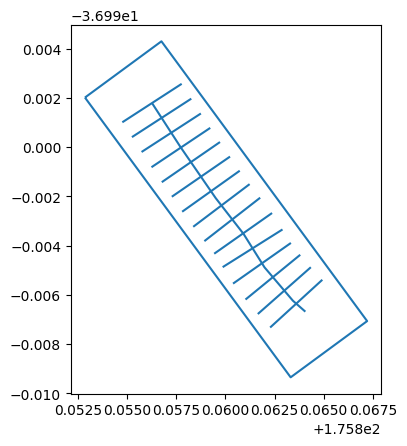

In [10]:
plt.clf()
ax = gpd.GeoSeries([shorelines.geometry[sitename], poly.geometry[sitename].exterior]).plot()
transects_gdf.plot(ax=ax)
plt.show()

In [11]:
ref_sl = np.array(line_merge(split(shorelines.geometry.to_crs(2193)[sitename], transects_gdf.to_crs(2193).unary_union)).coords)
ref_sl

array([[1854208.48953144, 5902621.1073155 ],
       [1854208.49016942, 5902621.10626722],
       [1854249.95792804, 5902552.96978902],
       [1854291.42537323, 5902484.83382582],
       [1854330.93567873, 5902419.91367679],
       [1854332.98442921, 5902416.75565941],
       [1854376.39934739, 5902349.83434937],
       [1854419.81395118, 5902282.91352393],
       [1854463.22822915, 5902215.99320073],
       [1854483.89360139, 5902184.1388557 ],
       [1854508.62812855, 5902150.43262295],
       [1854555.83180031, 5902086.10723937],
       [1854603.03517257, 5902021.78226392],
       [1854605.15326347, 5902018.89589927],
       [1854643.78057593, 5901953.24152413],
       [1854684.22224825, 5901884.50330348],
       [1854695.21790303, 5901865.81412223],
       [1854731.61493658, 5901820.52450901],
       [1854781.60310046, 5901758.32315944],
       [1854819.05800872, 5901711.71720992],
       [1854833.71105185, 5901698.07684236],
       [1854873.87099709, 5901660.69236125]])

In [12]:
settings["max_dist_ref"] = 100
settings["reference_shoreline"] = np.flip(ref_sl)

In [13]:
output = SDS_shoreline.extract_shorelines(metadata, settings)

L5: Mapping Shorelines:   0%|          | 0/81 [00:00<?, ?it/s]

L7: Mapping Shorelines:   0%|          | 0/515 [00:00<?, ?it/s]

L7 2019-01-23-21-54-21: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.


L8: Mapping Shorelines:   0%|          | 0/233 [00:00<?, ?it/s]

L8 2016-02-24-21-59-45: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2016-03-27-21-59-33: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2020-03-06-21-59-46: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2020-04-07-21-59-30: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2021-05-19-22-05-16: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2021-06-20-22-05-29: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.


In [14]:
# Have to flip to get x,y?
output['shorelines'] = [np.flip(s) for s in output['shorelines']]

In [15]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

0 duplicates
1 bad georef


In [16]:
from pyproj import CRS
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

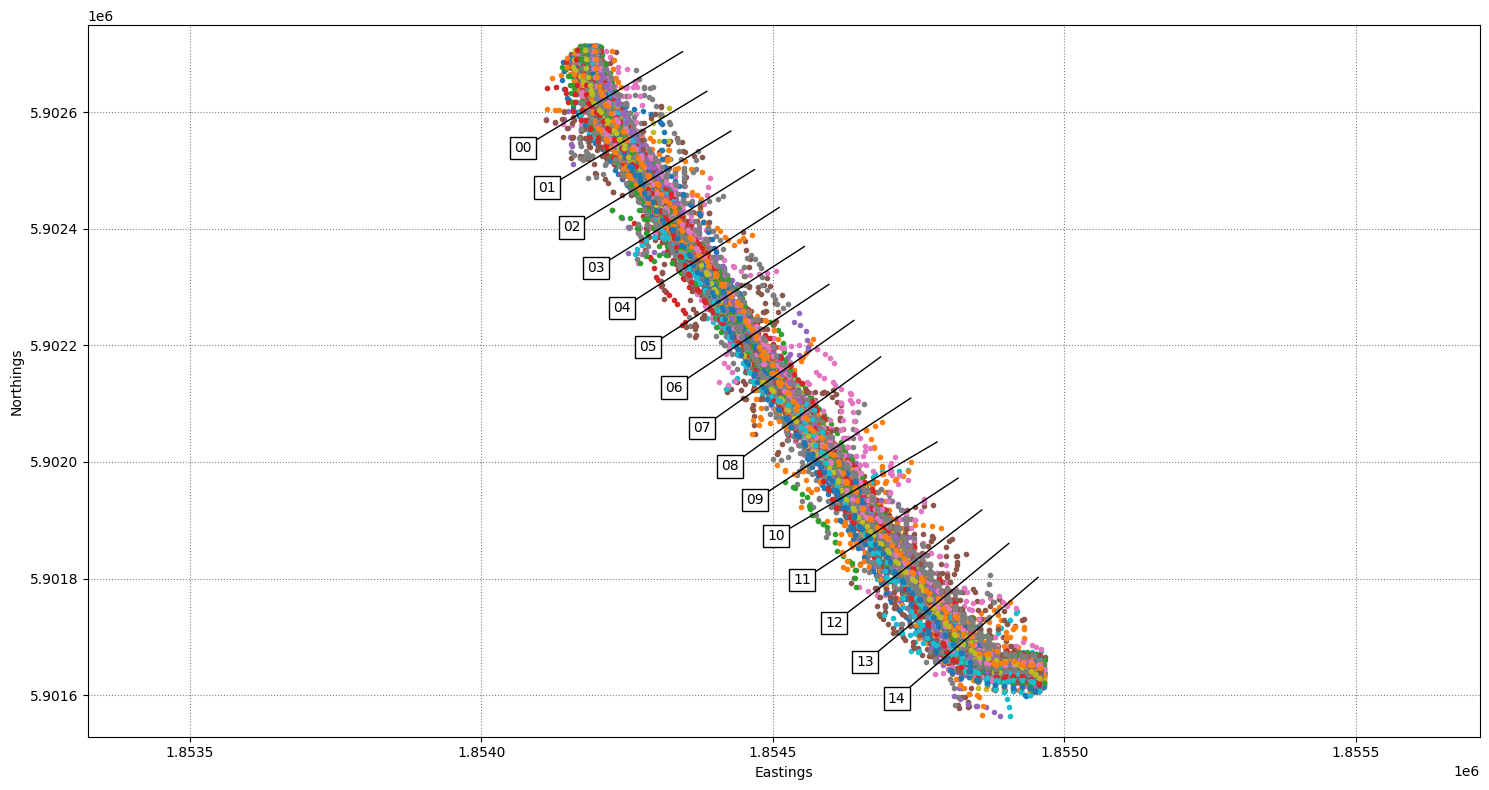

In [26]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0], transects[key][0,1], key.replace(f"{sitename}-00", ""),
                va='center', ha='center', bbox=dict(boxstyle="square", ec='k',fc='w'))
plt.show()

In [18]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':            0.1,       # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

Computing transect shoreline intersections:   0%|          | 0/15 [00:00<?, ?it/s]

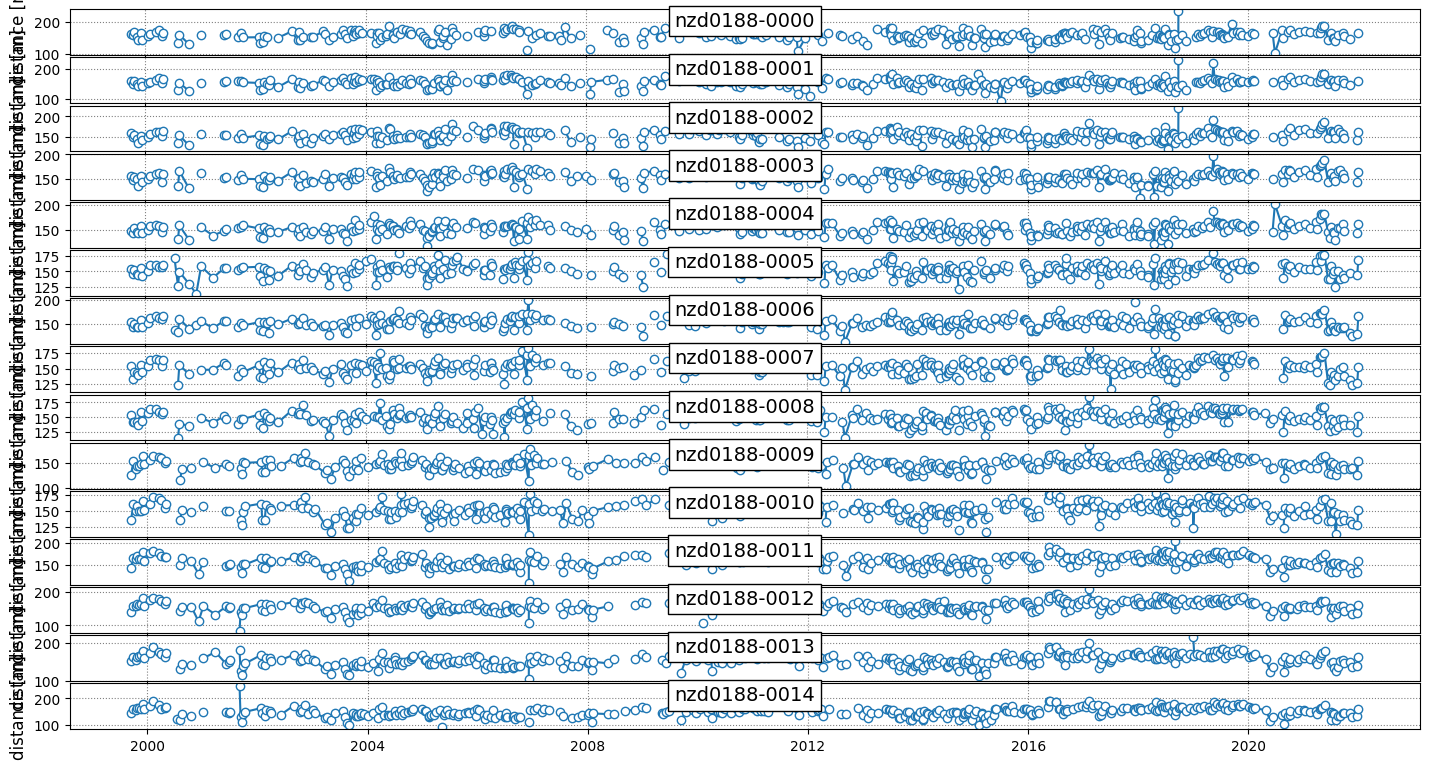

In [27]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(output['dates'], cross_distance[key], '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
plt.show()

In [20]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict['dates'] = output['dates']
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series.csv')
df.to_csv(fn, sep=',')
print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)

Time-series of the shoreline change along the transects saved as:
data/nzd0188/transect_time_series.csv


In [21]:
df.set_index("dates", inplace=True)

In [22]:
df.shape, vos.shape

((532, 15), (538, 15))

In [23]:
assert type(df.index) is type(vos.index)

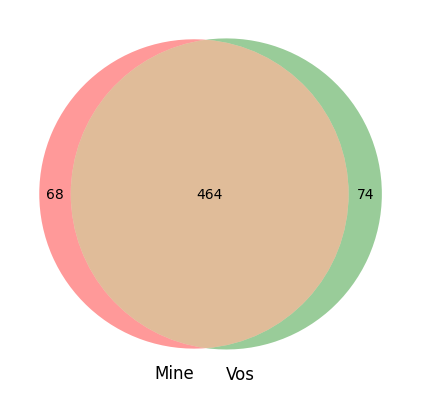

In [28]:
venn2([set(df.index), set(vos.index)], set_labels=('Mine', 'Vos'))
plt.show()

In [25]:
(df - vos).describe()

,nzd0188-0000,nzd0188-0001,nzd0188-0002,nzd0188-0003,nzd0188-0004,nzd0188-0005,nzd0188-0006,nzd0188-0007,nzd0188-0008,nzd0188-0009,nzd0188-0010,nzd0188-0011,nzd0188-0012,nzd0188-0013,nzd0188-0014
count,309.000000,338.000000,343.000000,345.000000,353.000000,344.000000,346.000000,343.000000,344.000000,351.000000,344.000000,324.000000,320.000000,350.000000,341.000000
mean,-44.487282,-38.409178,-37.862419,-37.116959,-36.222342,-35.887560,-35.247007,-34.763480,-33.760582,-33.166525,-34.638970,-35.957242,-34.138403,-33.984040,-29.558715
std,11.377866,9.124936,9.320802,8.356639,8.181054,8.218903,8.724123,8.557196,8.360091,8.709480,7.763055,8.051528,8.516822,8.586037,8.914667
min,-81.846501,-83.483175,-81.676694,-79.444361,-80.135210,-66.205440,-78.305259,-60.880462,-58.376719,-60.285409,-57.560262,-72.436305,-65.908870,-68.908646,-53.940074
25%,-51.437874,-44.251654,-43.548627,-42.732359,-41.576139,-41.330365,-40.199540,-40.064410,-38.837479,-38.490813,-39.780477,-41.317162,-39.511973,-39.765090,-35.462757
50%,-44.710985,-38.429163,-38.379229,-37.201581,-36.061338,-36.273141,-35.197051,-34.929764,-34.109598,-33.553596,-34.686978,-35.922316,-33.353859,-34.145173,-29.217657
75%,-37.059119,-32.257296,-31.665708,-31.080130,-29.829424,-28.929846,-29.491449,-29.062714,-27.970497,-27.776960,-29.329413,-30.426959,-27.644189,-27.767392,-24.351698
max,29.198338,-12.582230,37.847973,-10.003129,-11.624063,-15.757983,17.467547,4.904607,24.001645,31.164104,-10.927017,-10.801726,-1.743548,-4.917664,30.430775
